# Time-Series Forecasting of Carbon Monoxide and Nitrogen Dioxide Levels

Build predictive models to forecast daily or hourly concentrations of **CO(GT)** and **NO₂(GT)** based on historical data.


In [1]:
import pandas as pd
import numpy as np

In [2]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
data = pd.read_csv(url)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [3]:
data.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

# Project Workflow

### **Deliverables**:
1. **Forecasting Models**:
   - Trained models for `CO(GT)` and `NO₂(GT)`.
2. **Forecast Visualization**:
   - Plots showing historical trends and future predictions.
3. **Evaluation Report**:
   - Metrics and comparison of different forecasting models.
4. **Insights and Recommendations**:
   - Suggestions for mitigating high levels of these gases based on predictions.


### 1. Data Preprocessing
- **Date-Time Parsing**:
  - Combine the `Date` and `Time` columns into a single `datetime` column.
  - Set the `datetime` column as the index of the dataset.
- **Resampling**:
  - Aggregate the data into meaningful time intervals (e.g., hourly or daily averages).
- **Handle Missing Values**:
  - Use interpolation, mean, or advanced imputation techniques to fill missing data for `CO(GT)` and `NO₂(GT)`.
- **Outlier Detection**:
  - Remove or cap extreme values in `CO(GT)` and `NO₂(GT)` using statistical thresholds.

In [4]:
# Combine 'Date' and 'Time' columns into a single datetime column
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Set the newly created 'datetime' column as the index for the DataFrame
data.set_index('datetime', inplace=True)

# Drop the original 'Date' and 'Time' columns as they are no longer needed
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample the data to hourly frequency and compute the mean for each hour
data_resampled = data.resample('H').mean()

# Interpolate missing values using the time method (linear interpolation based on time index)
data_filled = data_resampled.interpolate(method='time')

# Define a function to remove outliers from a specific column using the IQR method
def remove_outliers(df, column):
    # Calculate the first quartile (Q1) and the third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Compute the interquartile range (IQR)
    IQR = Q3 - Q1
    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return a DataFrame excluding rows with outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the 'CO(GT)' column
data_cleaned = remove_outliers(data_filled, 'CO(GT)')

# Remove outliers from the 'NO2(GT)' column
data_cleaned = remove_outliers(data_cleaned, 'NO2(GT)')


C:\Users\User\AppData\Local\Temp\ipykernel_11940\401234809.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('H').mean()


### 2. Exploratory Data Analysis (EDA)
- **Trend Analysis**:
  - Visualize the long-term trends of `CO(GT)` and `NO₂(GT)`.
- **Seasonality**:
  - Identify seasonal patterns (e.g., daily or yearly fluctuations).
- **Correlation Analysis**:
  - Explore relationships between `CO(GT)`, `NO₂(GT)`, and other features (e.g., temperature or humidity).


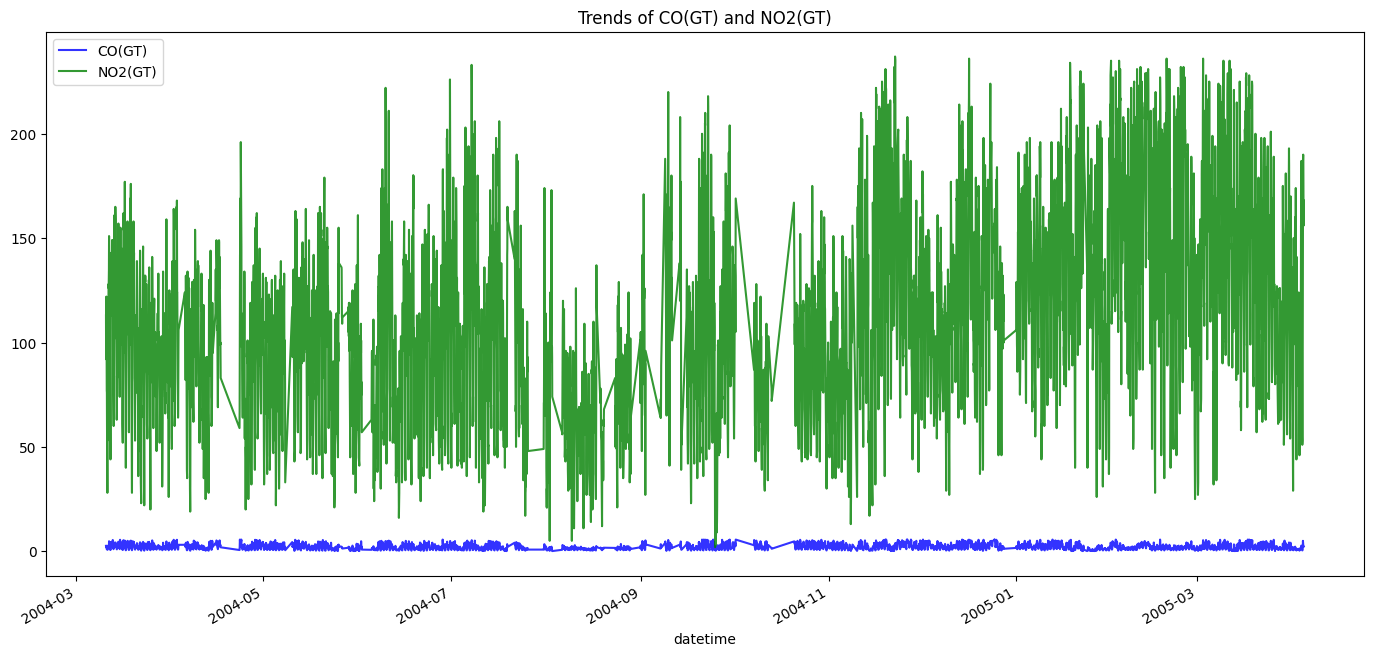

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 8))

# CO(GT) plotted in blue
data_cleaned['CO(GT)'].plot(label='CO(GT)', color='blue', alpha=0.8)

# NO2(GT) plotted in green
data_cleaned['NO2(GT)'].plot(label='NO2(GT)', color='green', alpha=0.8)

plt.legend()
plt.title('Trends of CO(GT) and NO2(GT)')
plt.show()


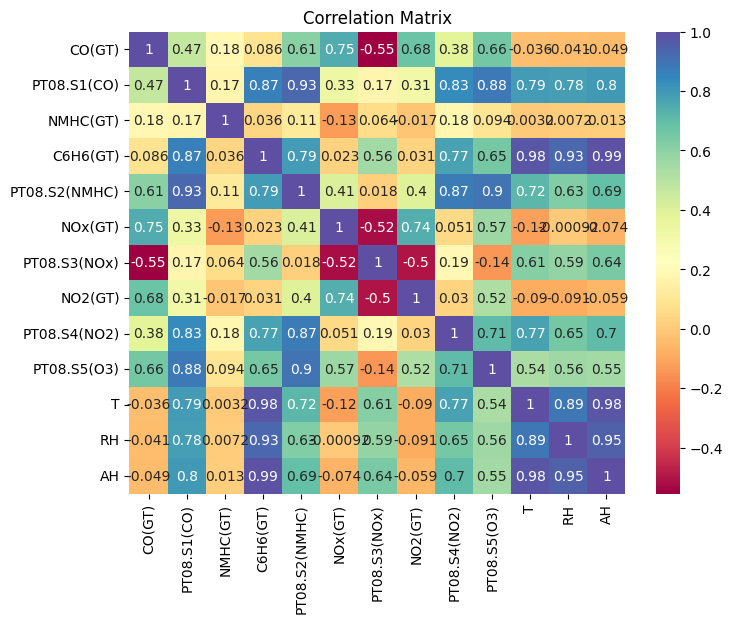

In [6]:
# Calculate the correlation matrix for the cleaned data
correlation_matrix = data_cleaned.corr()

# Import seaborn for visualization
import seaborn as sns

# Set the figure size for the heatmap
plt.figure(figsize=(8, 6))

# Create a heatmap to visualize the correlation matrix
# - annot=True: Annotates the heatmap with correlation values
# - cmap='Spectral': Specifies the color map for the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral')

# Add a title to the heatmap for better context
plt.title('Correlation Matrix')

# Display the heatmap
plt.show()
 


### 3. Feature Engineering
- Create lag features for `CO(GT)` and `NO₂(GT)` to incorporate historical values.
- Add time-based features (e.g., hour of the day, day of the week, month).
- Include environmental factors (`T`, `RH`, `AH`) as predictors.


In [7]:
for lag in range(1, 25):  # Lags up to 24 hours
    data_cleaned[f'CO(GT)_lag_{lag}'] = data_cleaned['CO(GT)'].shift(lag)
    data_cleaned[f'NO2(GT)_lag_{lag}'] = data_cleaned['NO2(GT)'].shift(lag)

In [8]:
data_cleaned['hour'] = data_cleaned.index.hour
data_cleaned['day_of_week'] = data_cleaned.index.dayofweek
data_cleaned['month'] = data_cleaned.index.month

### 4. Time-Series Forecasting
- Train separate models for **CO(GT)** and **NO₂(GT)**.
- Explore the following forecasting approaches:
  - **Statistical Models**:
    - Classical models like ARIMA or SARIMA for univariate forecasting.
  - **Machine Learning Models**:
    - Use regression models trained on lag features and external predictors.
  - **Deep Learning Models**:
    - Apply LSTM, GRU, or other RNN-based models for sequence forecasting.
- Evaluate and compare the models.


In [9]:
data_model = data_cleaned.dropna()

train = data_model.loc[:'2004-12-31']
test = data_model.loc['2005-01-01':]

X_train = train.drop(['CO(GT)', 'NO2(GT)'], axis=1)
y_train_CO = train['CO(GT)']
y_train_NO2 = train['NO2(GT)']

X_test = test.drop(['CO(GT)', 'NO2(GT)'], axis=1)
y_test_CO = test['CO(GT)']
y_test_NO2 = test['NO2(GT)']

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model_CO = ARIMA(train['CO(GT)'], order=(2, 1, 2))
model_CO_fit = model_CO.fit()

forecast_CO = model_CO_fit.forecast(steps=len(test))

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availab

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_model_NO2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_NO2.fit(X_train, y_train_NO2)

predictions_NO2 = rf_model_NO2.predict(X_test)

### 5. Model Evaluation
- Use appropriate metrics for forecasting:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Percentage Error (MAPE)
- Plot actual vs. predicted values to visualize performance.


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_CO = mean_absolute_error(y_test_CO, forecast_CO)
rmse_CO = mean_squared_error(y_test_CO, forecast_CO, squared=False)

mae_NO2 = mean_absolute_error(y_test_NO2, predictions_NO2)
rmse_NO2 = mean_squared_error(y_test_NO2, predictions_NO2, squared=False)

print(f"CO(GT) - MAE:> {mae_CO}, RMSE:> {rmse_CO}")
print(f"NO2(GT) - MAE:> {mae_NO2}, RMSE:> {rmse_NO2}")

CO(GT) - MAE:> 1.051371243502635, RMSE:> 1.2309420851806439
NO2(GT) - MAE:> 13.748012232415903, RMSE:> 18.56367486697525


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


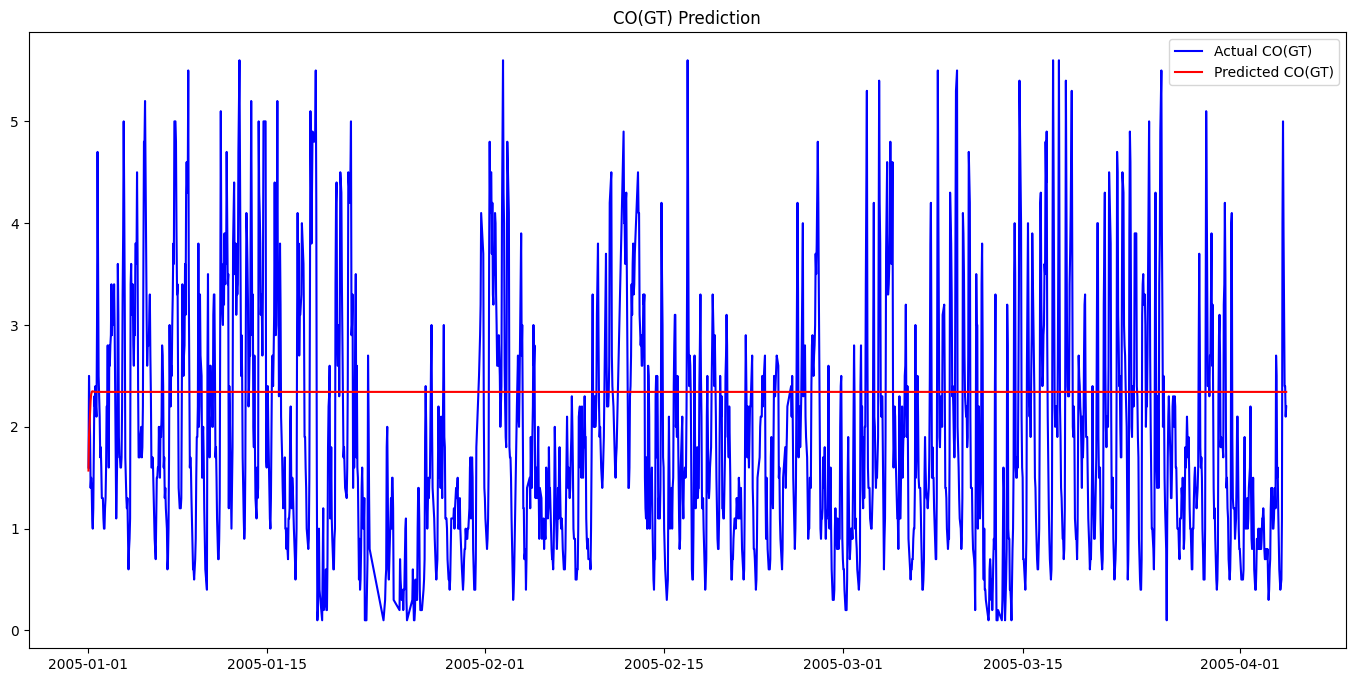

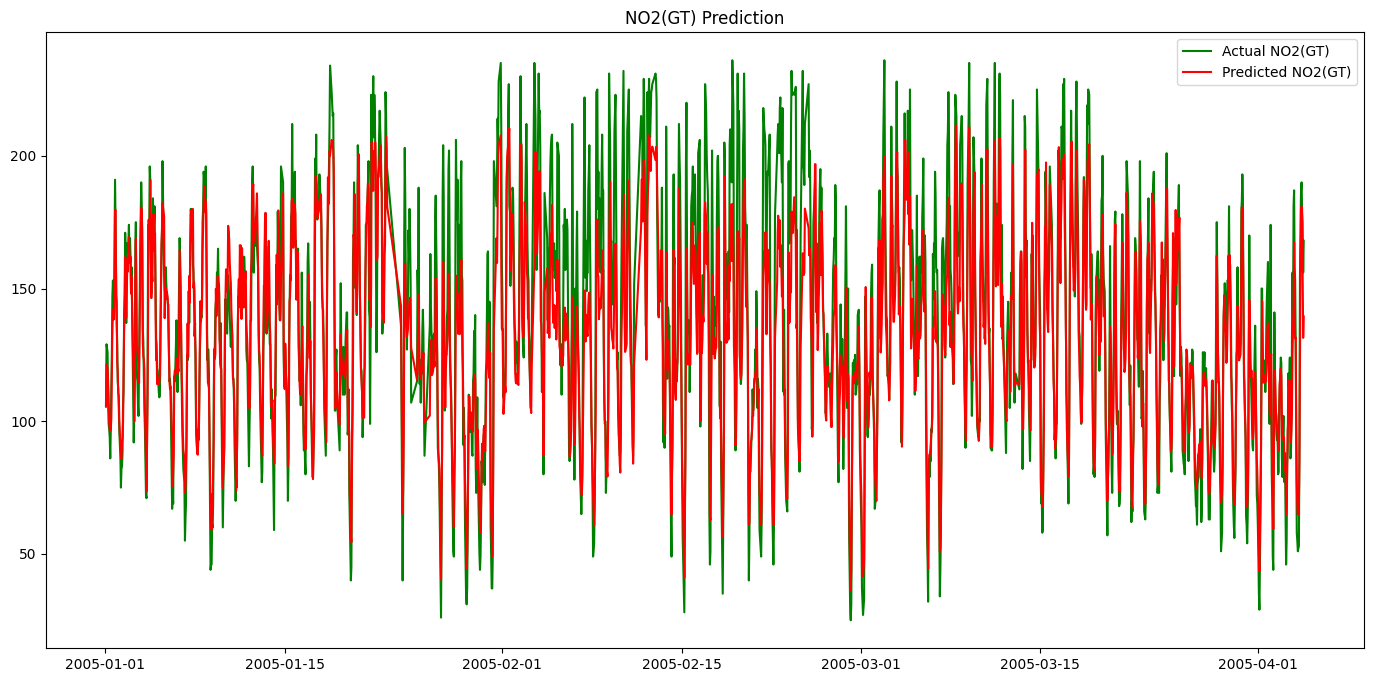

In [13]:
# Plot for CO(GT) Prediction
plt.figure(figsize=(17, 8))
plt.plot(test.index, y_test_CO, label='Actual CO(GT)', color='blue') 
plt.plot(test.index, forecast_CO, label='Predicted CO(GT)', color='red')  
plt.legend()
plt.title('CO(GT) Prediction')
plt.show()

# Plot for NO2(GT) Prediction
plt.figure(figsize=(17, 8))
plt.plot(test.index, y_test_NO2, label='Actual NO2(GT)', color='green')  
plt.plot(test.index, predictions_NO2, label='Predicted NO2(GT)', color='red')  
plt.legend()
plt.title('NO2(GT) Prediction')
plt.show()


### 6. Visualization and Insights
- Generate forecasts for future dates and visualize the trends.
- Highlight seasonal patterns, peak times, and periods of concern.
- Provide actionable recommendations based on predicted trends.



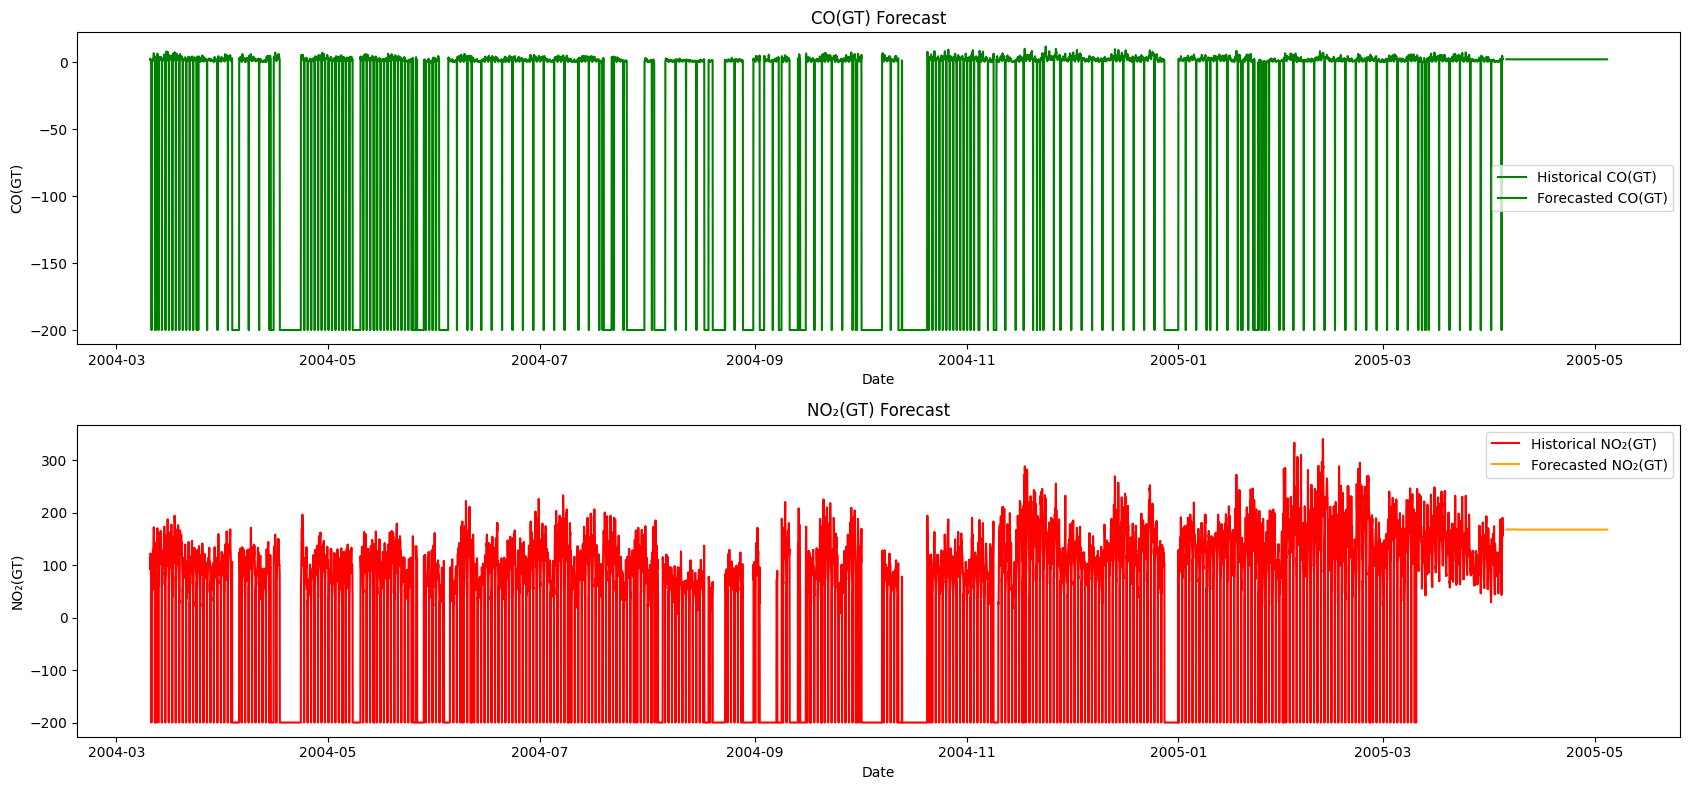

In [14]:
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
arima_co = ARIMA(data_resampled['CO(GT)'], order=(5,1,0)) 
arima_co_fit = arima_co.fit()

arima_no2 = ARIMA(data_resampled['NO2(GT)'], order=(5,1,0))  
arima_no2_fit = arima_no2.fit()

forecast_days = 30
forecast_co = arima_co_fit.forecast(steps=forecast_days)
forecast_no2 = arima_no2_fit.forecast(steps=forecast_days)

future_dates = pd.date_range(data_resampled.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')

plt.figure(figsize=(17, 8))
plt.subplot(2, 1, 1)
plt.plot(data_resampled.index, data_resampled['CO(GT)'], label='Historical CO(GT)', color='green')
plt.plot(future_dates, forecast_co, label='Forecasted CO(GT)', color='g')
plt.title('CO(GT) Forecast')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_resampled.index, data_resampled['NO2(GT)'], label='Historical NO₂(GT)', color='red')
plt.plot(future_dates, forecast_no2, label='Forecasted NO₂(GT)', color='orange')
plt.title('NO₂(GT) Forecast')
plt.xlabel('Date')
plt.ylabel('NO₂(GT)')
plt.legend()

plt.tight_layout()
plt.show()

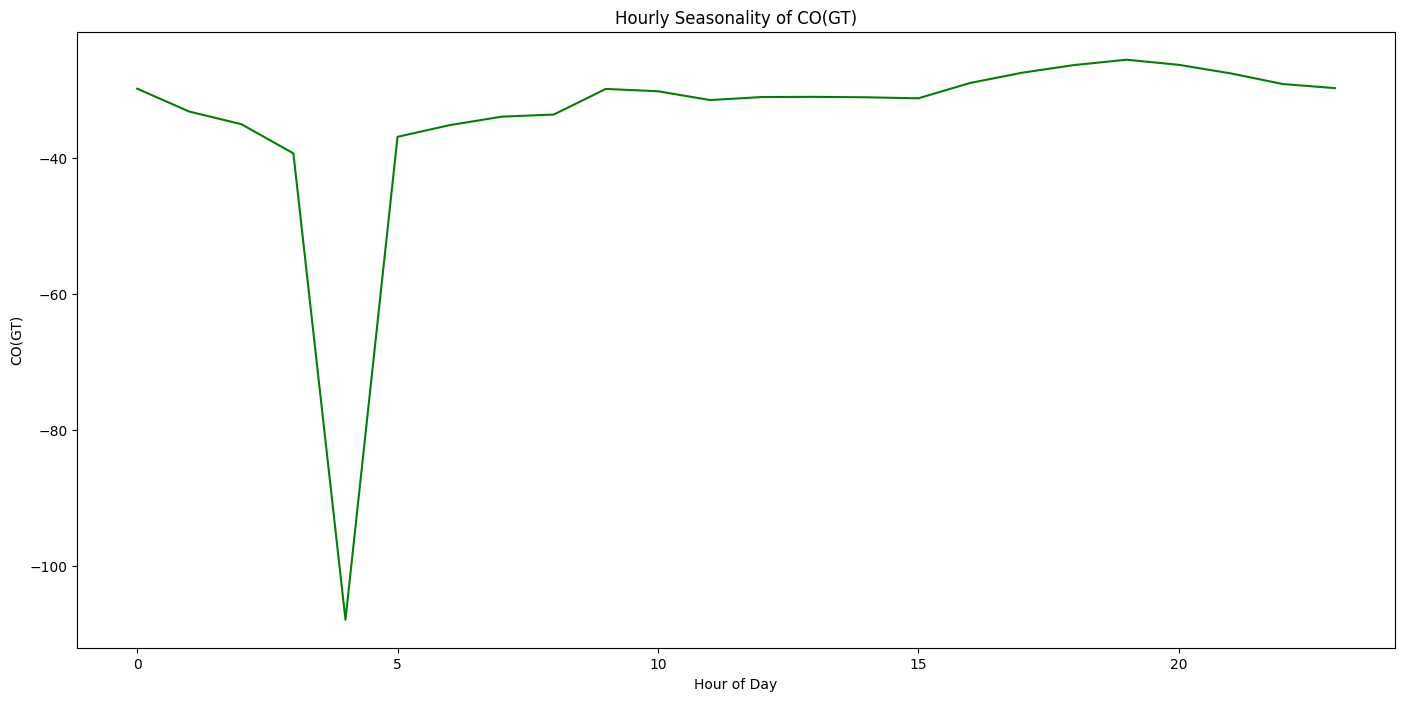

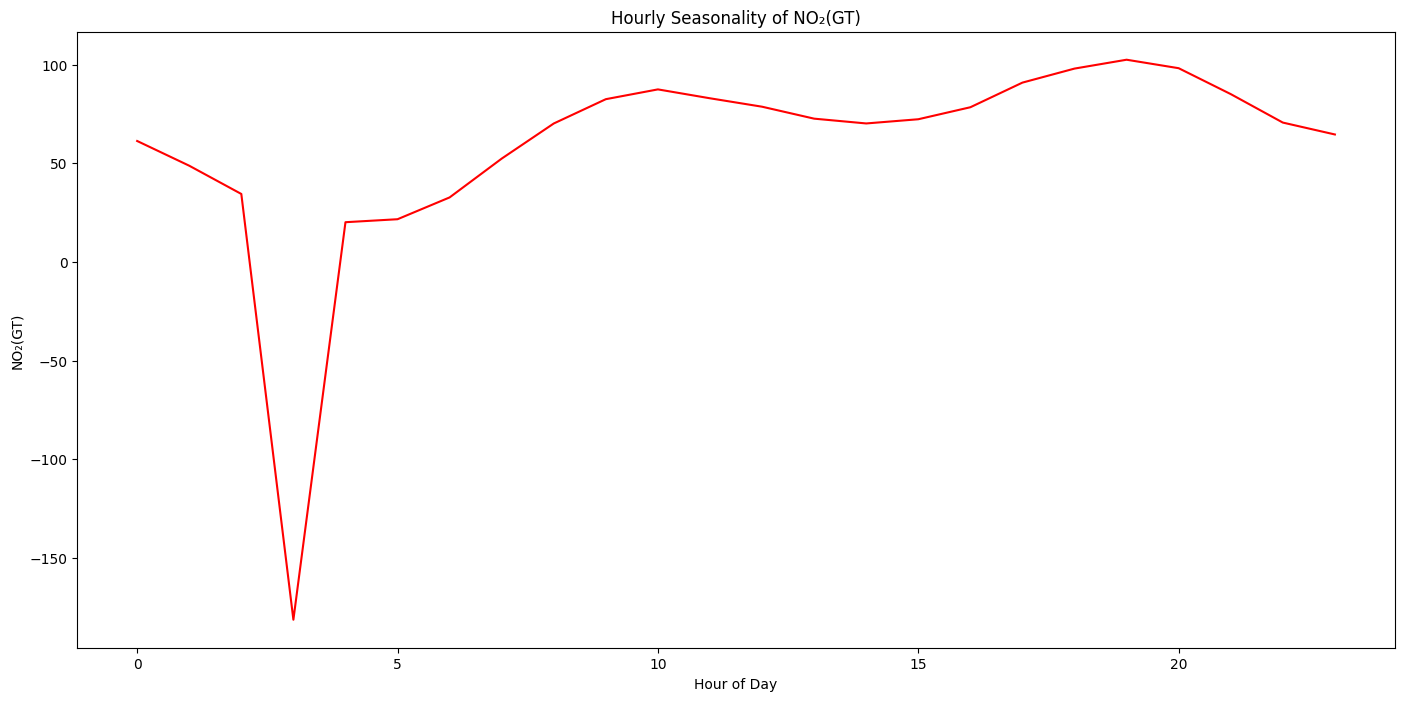

In [15]:
data_resampled['hour'] = data_resampled.index.hour 

plt.figure(figsize=(17, 8))
data_resampled.groupby('hour')['CO(GT)'].mean().plot(label='CO(GT)', color='green')
plt.title('Hourly Seasonality of CO(GT)')
plt.xlabel('Hour of Day')
plt.ylabel('CO(GT)')
plt.show()

plt.figure(figsize=(17, 8))
data_resampled.groupby('hour')['NO2(GT)'].mean().plot(label='NO₂(GT)', color='red')
plt.title('Hourly Seasonality of NO₂(GT)')
plt.xlabel('Hour of Day')
plt.ylabel('NO₂(GT)')
plt.show()